# First Paper: Risk-based approach to the OTS problem

## Set up

In [1]:
using Gurobi
env = Gurobi.Env()
include("includes/DrawGrid.jl")
include("includes/GraphUtils.jl")
include("includes/dcpf.jl")
include("includes/tnr.jl")
include("includes/tnrOptim.jl")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-05


secured_dc_OTS (generic function with 1 method)

In [2]:
using Logging
debuglogger = ConsoleLogger(stderr, Logging.Warn)
global_logger(debuglogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(20) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
function calcanddraw(g; bus_orig=nothing, outages=Int[], trip=nothing, label="", kwargs...)
    bus_orig = isnothing(bus_orig) ? label_for(g, 1) : bus_orig
    g_cc = connected(g, bus_orig, outages=outages, trip=trip)

    if nv(g) == nv(g_cc)
        h = g
        houtages = outages
        htrip = trip
    else
        h = g_cc
        balance!(h)
        houtages = Int[]
        htrip = nothing
        label = label == "" ? "" : L"\textbf{%$label}(%$(floor(Int, 100*(total_load(g)-total_load(g_cc)))))"
    end

    dc_draw = dc_flow(h, outages=houtages, trip=htrip, pf_type=pf_linalg)
    draw(dc_draw, outages=houtages, trip=htrip, title=label,
        edge_width=br -> br.outage || br.trip ? 6 : 2,
        ; kwargs...)
end

function griddraw(g, bus_orig::String, trips::AbstractArray{Int}, outages=Int[]; kwargs...)
    fig = Figure(size=(600, 500), fontsize=20)
    splitlength = 5
    all_edges = collect(edges(g))
    for (i, trip) in enumerate(trips)
        e = all_edges[trip]
        label = "$(label_for(g, src(e)))$(label_for(g, dst(e)))"

        if !(trip in outages)
            draw(
                g,
                outages=outages,
                trip=trip,
                fig=fig[1, 1][(i-1)÷splitlength, (i-1)%splitlength],
                node_labels=nothing,
                edge_labels=nothing,
                arrow_size=0,
                node_size=nothing,
                edge_width=br -> br.trip || (abs(br.p > br.p_max + 1e-6)) ? 4 : 2,
                edge_coloring=br -> br.trip ? :black : br.outage ? :white : :black,
                layout=layout)

            calcanddraw(
                g,
                bus_orig=bus_orig,
                outages=outages,
                trip=trip,
                fig=fig[1, 1][(i-1)÷splitlength, (i-1)%splitlength],
                node_labels=nothing,
                edge_labels=nothing,
                arrow_size=0,
                node_size=nothing,
                edge_width=br -> br.trip || (abs(br.p > br.p_max + 1e-6)) ? 4 : 2,
                edge_coloring=br -> br.trip ? :black : br.outage ? :transparent : (abs(br.p > br.p_max + 1e-6)) ? :red : :green3,
                layout=layout,
                label=L"%$label", kwargs...)

        end
    end
    fig
end


griddraw (generic function with 2 methods)

In [4]:
case = "case14"
buslabels = num -> "$(labs[num])"

labs = collect('A':'Z')
sys = System(joinpath("data", "$case.m"))
g = network2graph(sys, buslabels)

add_constraint(g, b -> b.p_max = 1.1)
g["N"] = 1
g["H"] = 0.1
g["H"] = 0.5
g["A", "B"].p_max = 3
g["B", "D"].p_max = 3
g["A", "E"].p_max = 3
g["D", "E"].p_max = 1.7
g["B", "E"].p_max = 0.9
g["D", "I"].p_max = 0.33

balance!(g, all_non_zero_uniform)

coord = load_coord(joinpath("data", "$case.csv"), buslabels)
layout = isa(coord, Dict{String, Point2}) ? coord : Stress(Ptype=Float32)

trips = [2, 5, 4, 16, 10, 3, 6, 11, 19, 20, 1, 14, 15, 13, 12, 17, 18, 7, 9, 8]

┌ Warning: Invalid range
│   valid_info.struct_name = "ACBus"
│   field_name = "magnitude"
│   valid_range = "voltage_limits"
│   valid_info.ist_struct =
│    Bus 6     LV (ACBus):
│       number: 6
│       name: Bus 6     LV
│       bustype: ACBusTypes.PV = 2
│       angle: -0.24818581963359368
│       magnitude: 1.07
│       voltage_limits: (min = 0.94, max = 1.06)
│       base_voltage: 0.0
│       area: 1 (Area)
│       load_zone: nothing
│       ext: Dict{String, Any}()
│       InfrastructureSystems.SystemUnitsSettings:
│          base_value: 100.0
│          unit_system: UnitSystem.SYSTEM_BASE = 0
└ @ InfrastructureSystems ~/.julia/packages/InfrastructureSystems/9btGb/src/validation.jl:219
┌ Warning: Invalid range
│   valid_info.struct_name = "ACBus"
│   field_name = "magnitude"
│   valid_range = "voltage_limits"
│   valid_info.ist_struct =
│    Bus 7     ZV (ACBus):
│       number: 7
│       name: Bus 7     ZV
│       bustype: ACBusTypes.PQ = 1
│       angle: -0.23335052099164186

20-element Vector{Int64}:
  2
  5
  4
 16
 10
  3
  6
 11
 19
 20
  1
 14
 15
 13
 12
 17
 18
  7
  9
  8

## Run

### Initial state

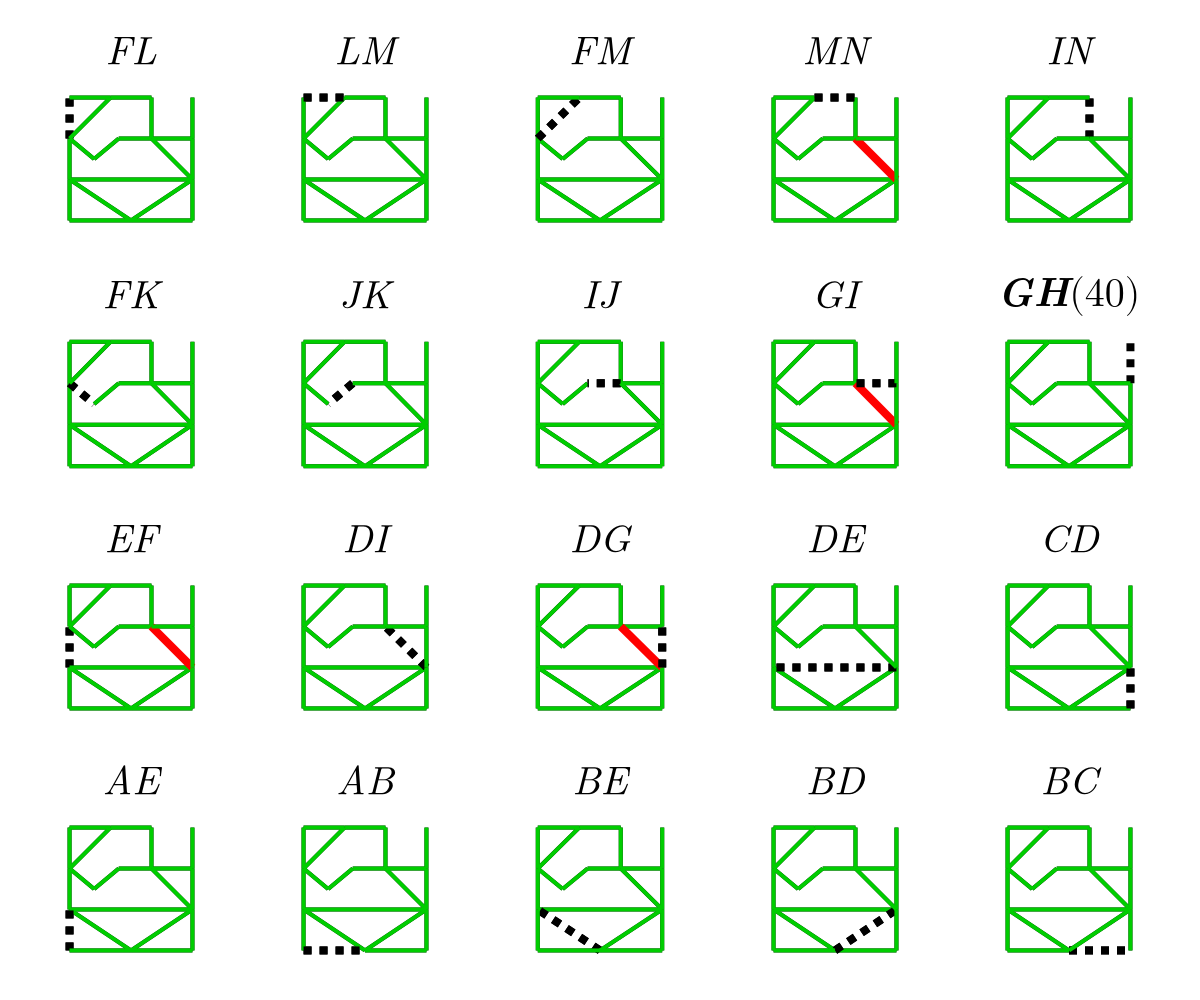

In [5]:
griddraw(g, "A", trips)

### Optimization

* Solver : Gurobi

* Status
  Result count       : 3
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.73508e+00
  Objective bound    : 3.73508e+00
  Relative gap       : 0.00000e+00
  Dual objective value : 3.73508e+00

* Work counters
  Solve time (sec)   : 1.85454e+00
  Barrier iterations : 0
  Node count         : 139


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-05
Set parameter DualReductions to value 0
Set parameter DualReductions to value 0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10302 rows, 3490 columns and 41010 nonzeros
Model fingerprint: 0xb1d57e3e
Variable types: 1930 continuous, 1560 integer (1560 binary)
Coefficient statistics:
  Matrix range     [3e-04, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e+00, 5e+00]
  RHS range        [4e-03, 2e+01]
Presolve removed 4580 rows and 1445 columns
Presolve time: 0.07s
Presolved: 5722 rows, 2045 columns, 25249 nonzeros
Variable types: 1162 continuous, 883 integer (883 binary)

Root relaxation: objective 5.386966e-01, 2891 iterations, 0.08 seconds (0.15 

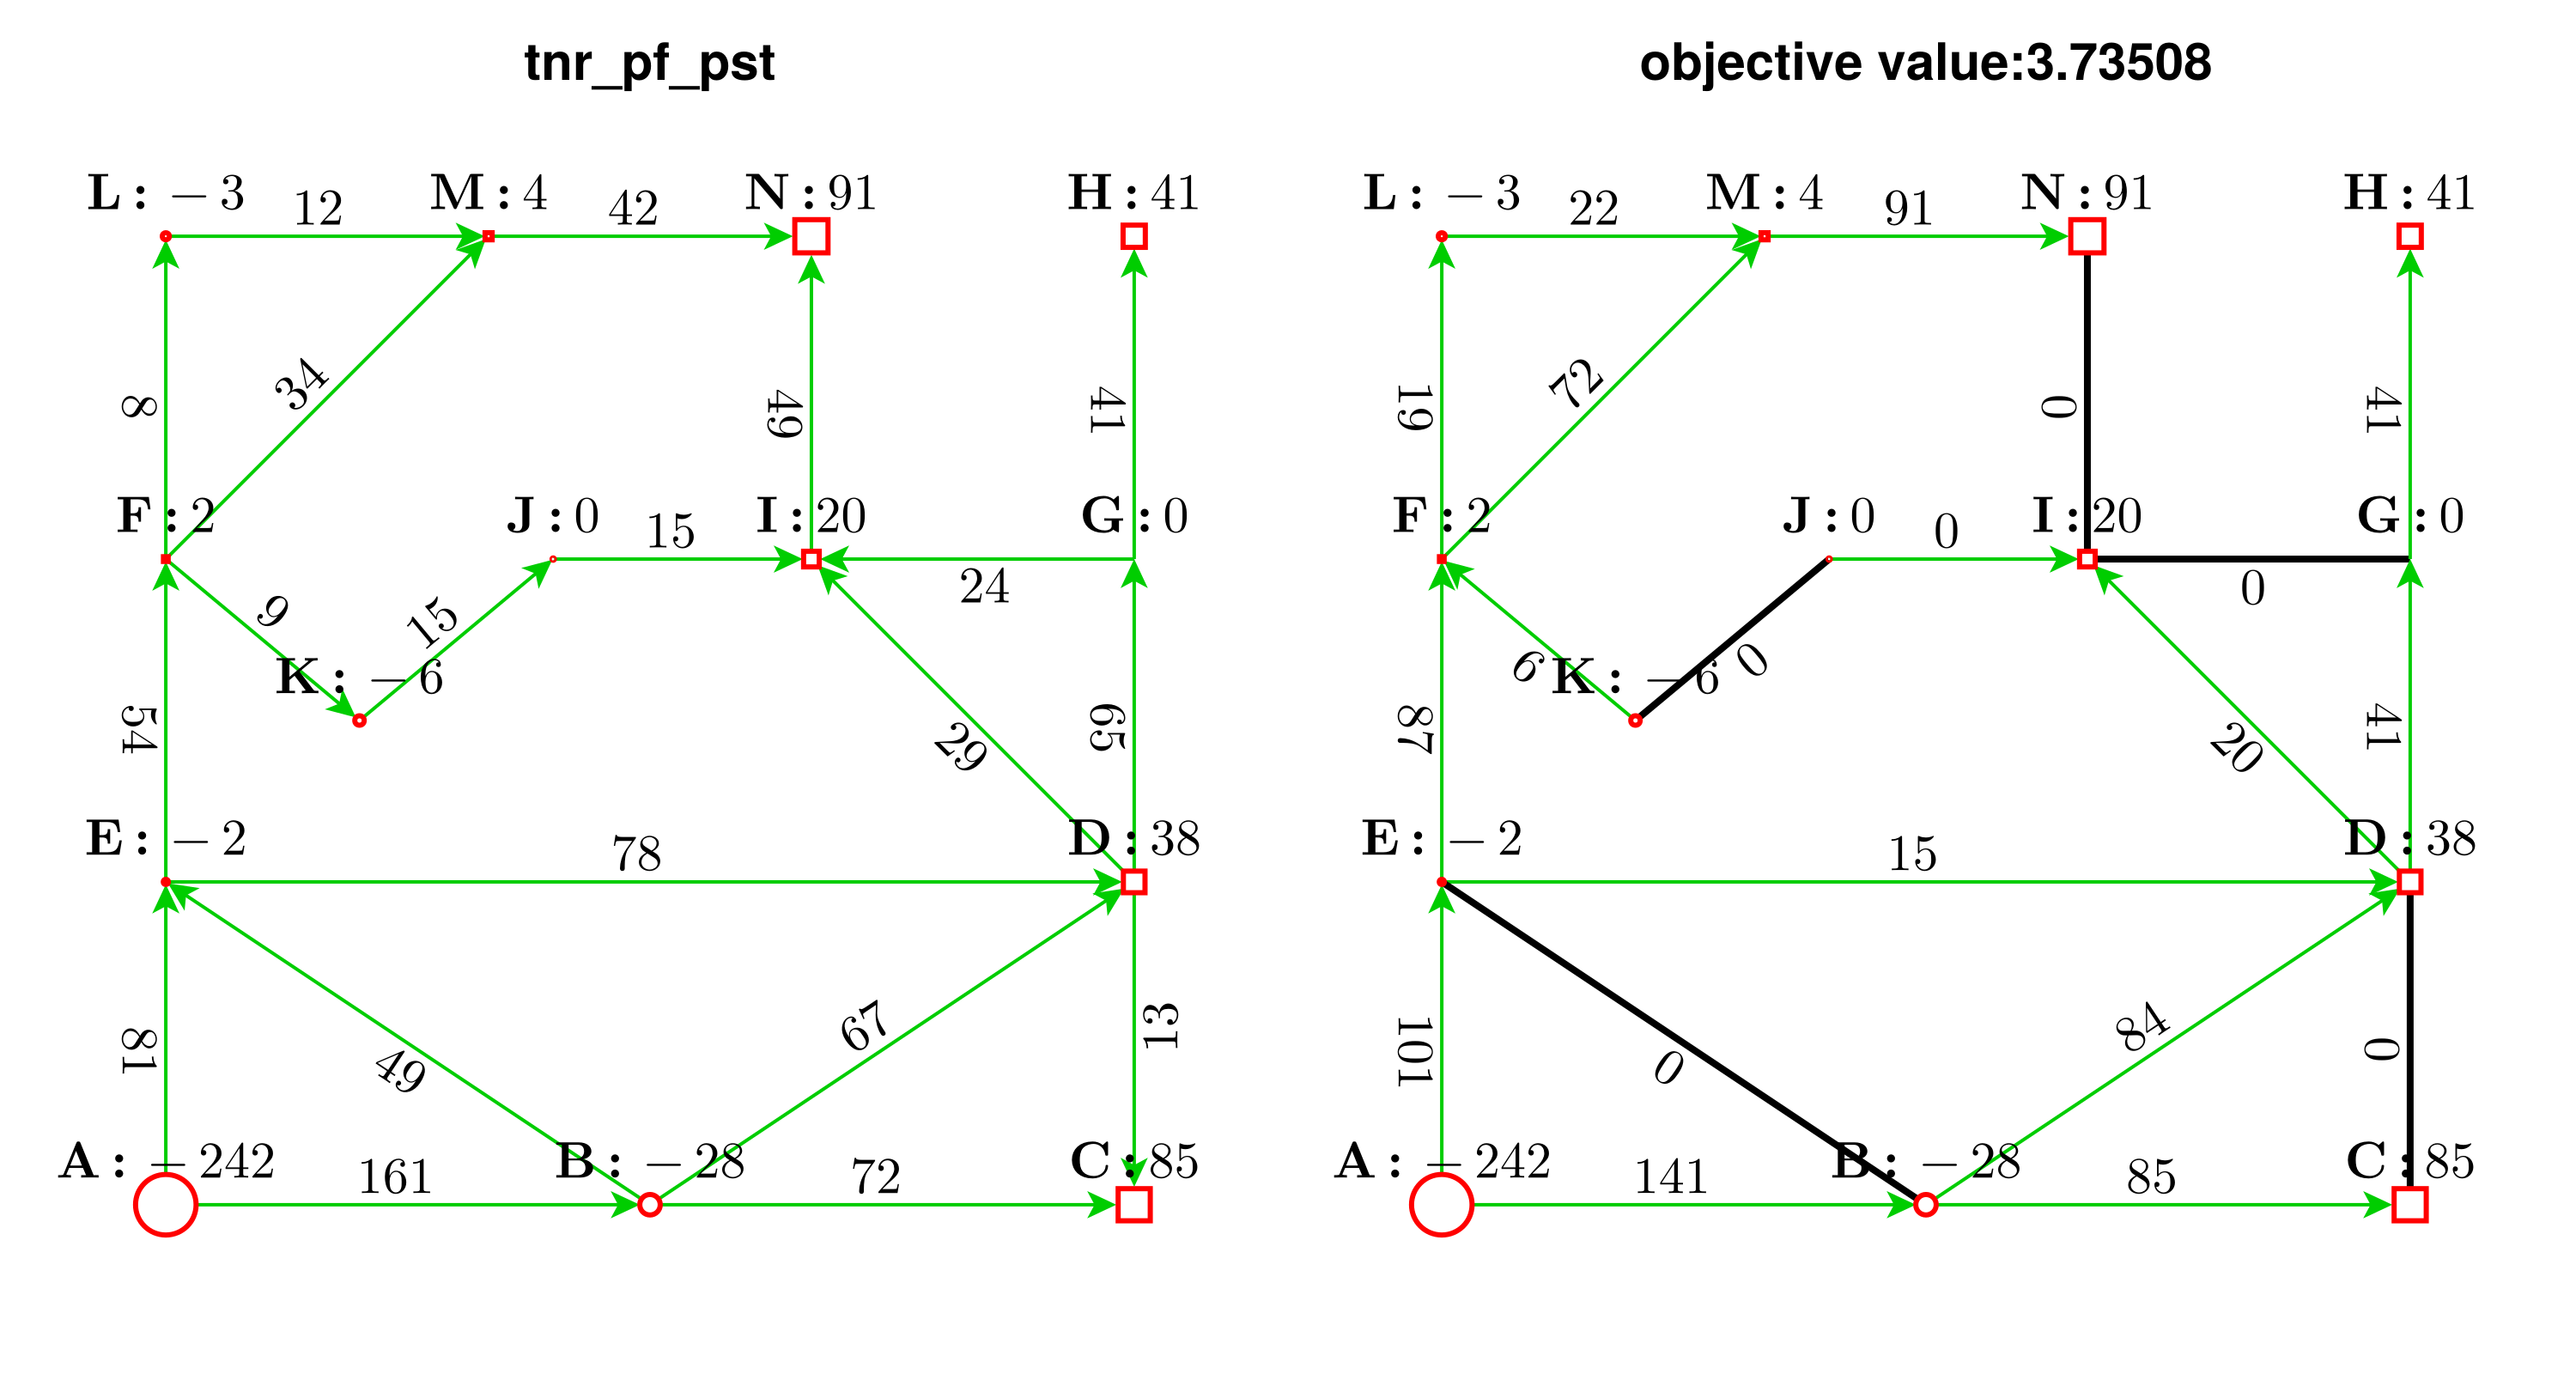

CairoMakie.Screen{IMAGE}


In [6]:
model, r = secured_dc_OTS(g,
                contingencies = 1:20,
                is_single_ρ = true,
                ρ_min_bound = 1.,
                allow_branch_openings = true,
                OTS_only = true,
                tnr_pf = tnr_pf_pst
                )

optimize!(model);

fig = Figure(size = (1500, 800), fontsize = 30)

trip = nothing #12
g_base = dc_flow(g, trip = trip)
draw(g_base, fig = fig[1,1], trip = trip, layout = layout, title = "$(r.tnr_pf)");

openings = Int[]
applied_conf=BusConf[]

report = []

display(solution_summary(model))

if is_solved_and_feasible(model)
    println("Overload: $(value(model[:overload]))")

    if r.allow_branch_openings || r.OTS_only
        push!
        openings = [i for (i, v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
        println("Open: $openings")
        println([collect(edge_labels(g))[i] for i in openings])
    end
    
    if r.bus_confs ≠ BusConf[] && !r.OTS_only
        println("v_bus: $(value.(model[:v_bus]))")
        applied_conf = BusConf[r.bus_confs[i] for (i, v) in enumerate(value.(model[:v_bus])) if isapprox(v, 1, atol=1e-9)]
        println("Applied_conf: $applied_conf")
    end
    g_result, openings_result = add_subBus(g, applied_conf, openings)
    dc_flow!(g_result, outages = [openings_result])
    draw(g_result , fig = fig[1,2], outages = openings_result, layout = layout, title = "objective value:$(round(objective_value(model); digits = 5 ))");
    println("OK")
else
    println("NOT FEASIBLE")
end

display(fig)

### Resulting state

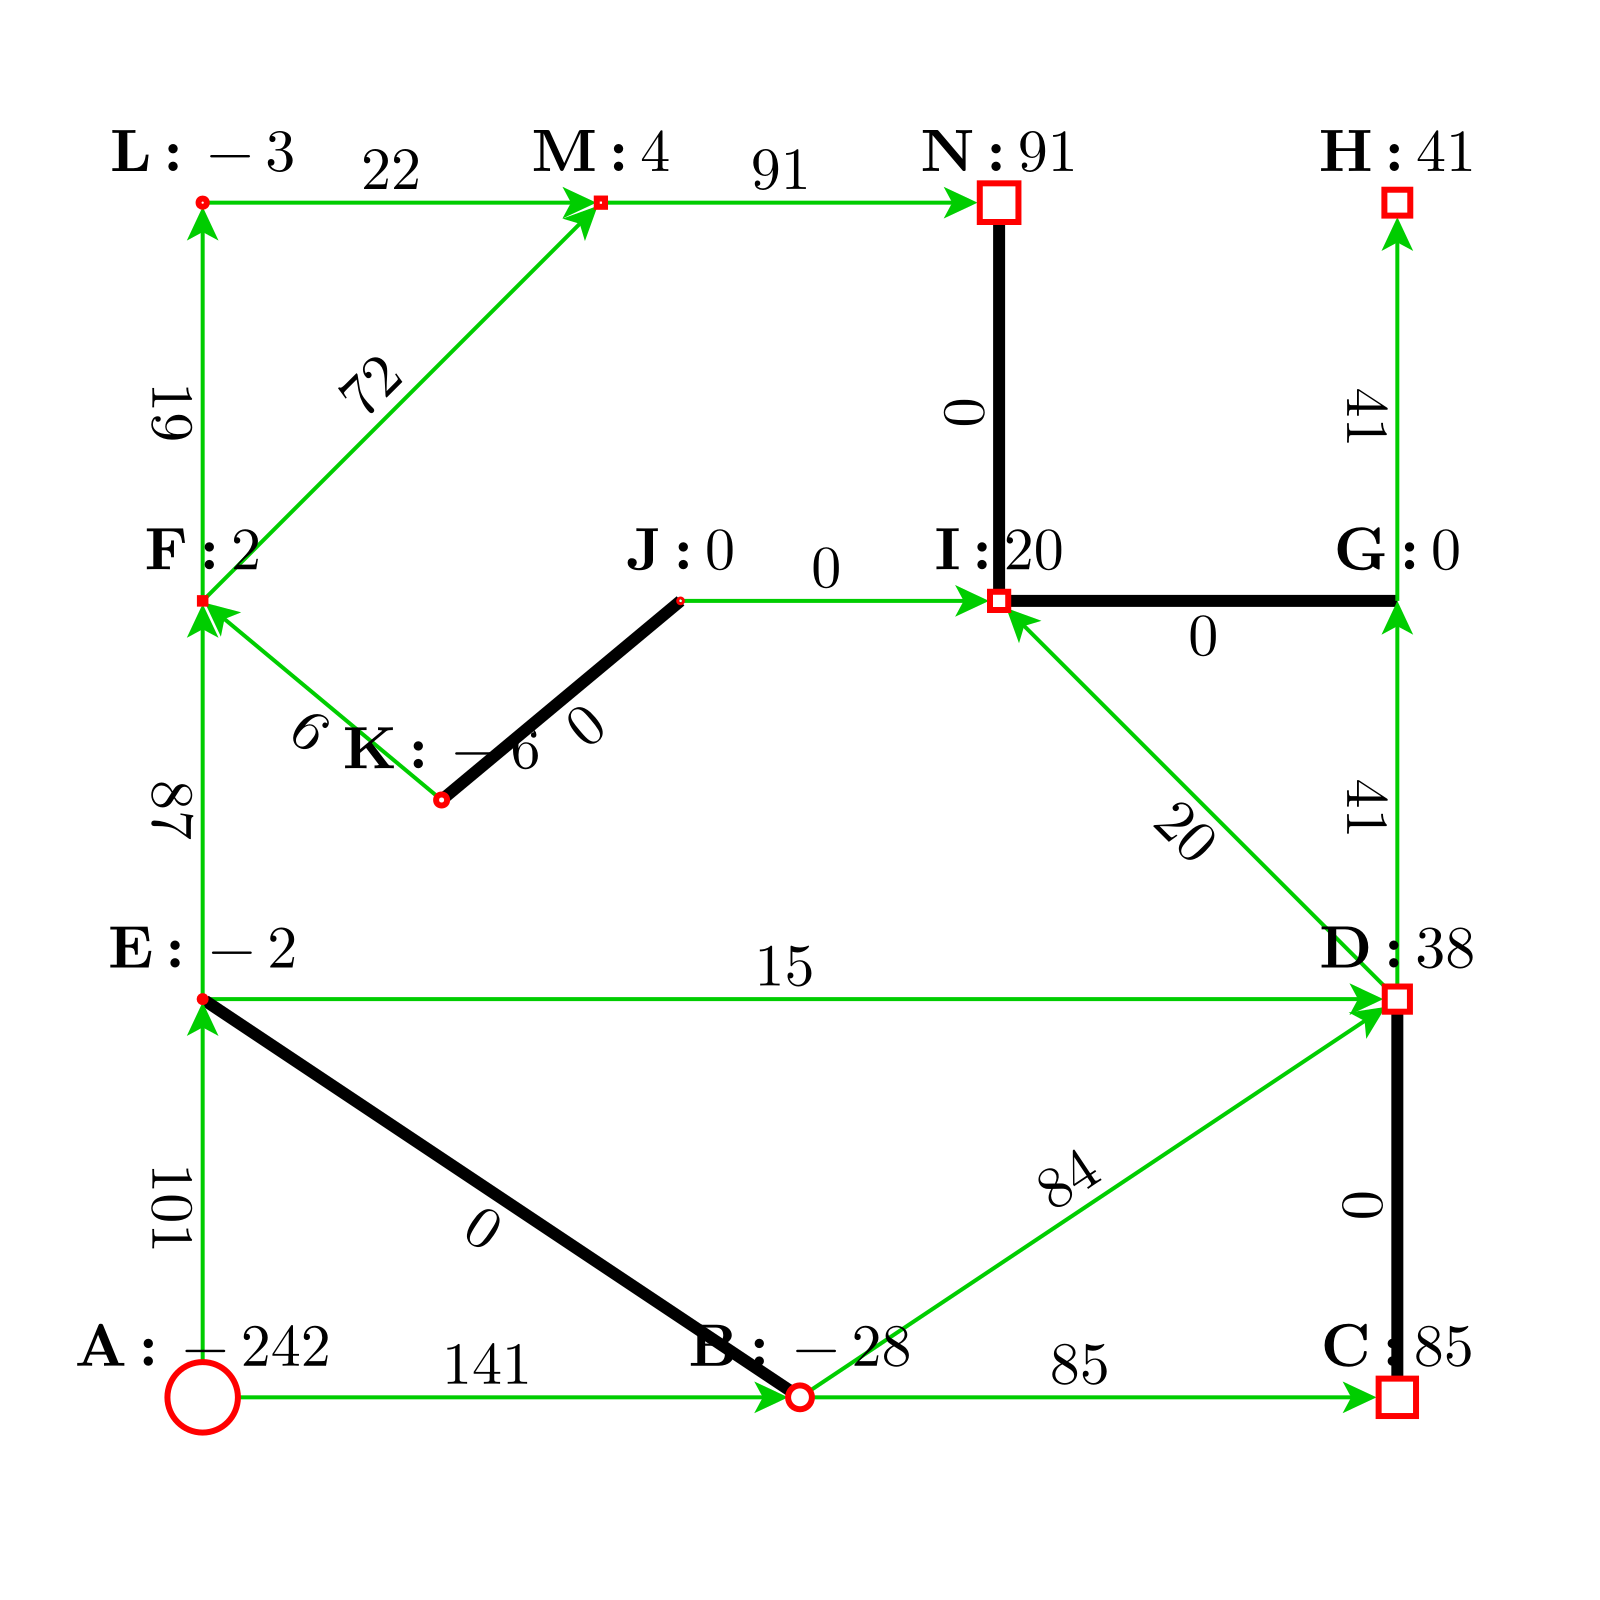

CairoMakie.Screen{IMAGE}


In [7]:
fig = Figure(size = (800, 800), fontsize = 30)
calcanddraw(g, bus_orig="A", outages = openings, layout = layout, fig=fig[1,1])
display(fig)

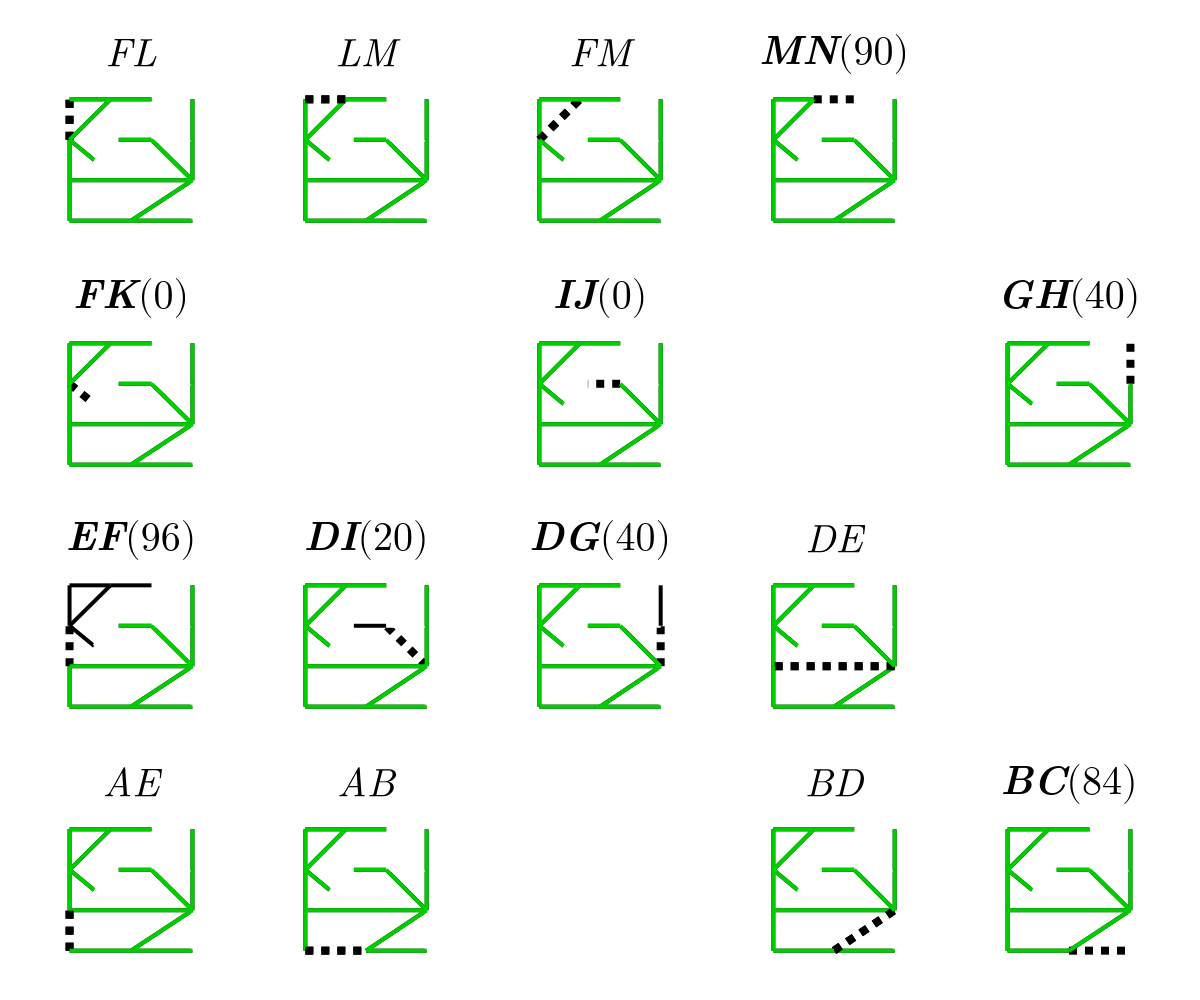

In [8]:
griddraw(g, "A", trips, openings)

### Intermediate state if only considering the northern part

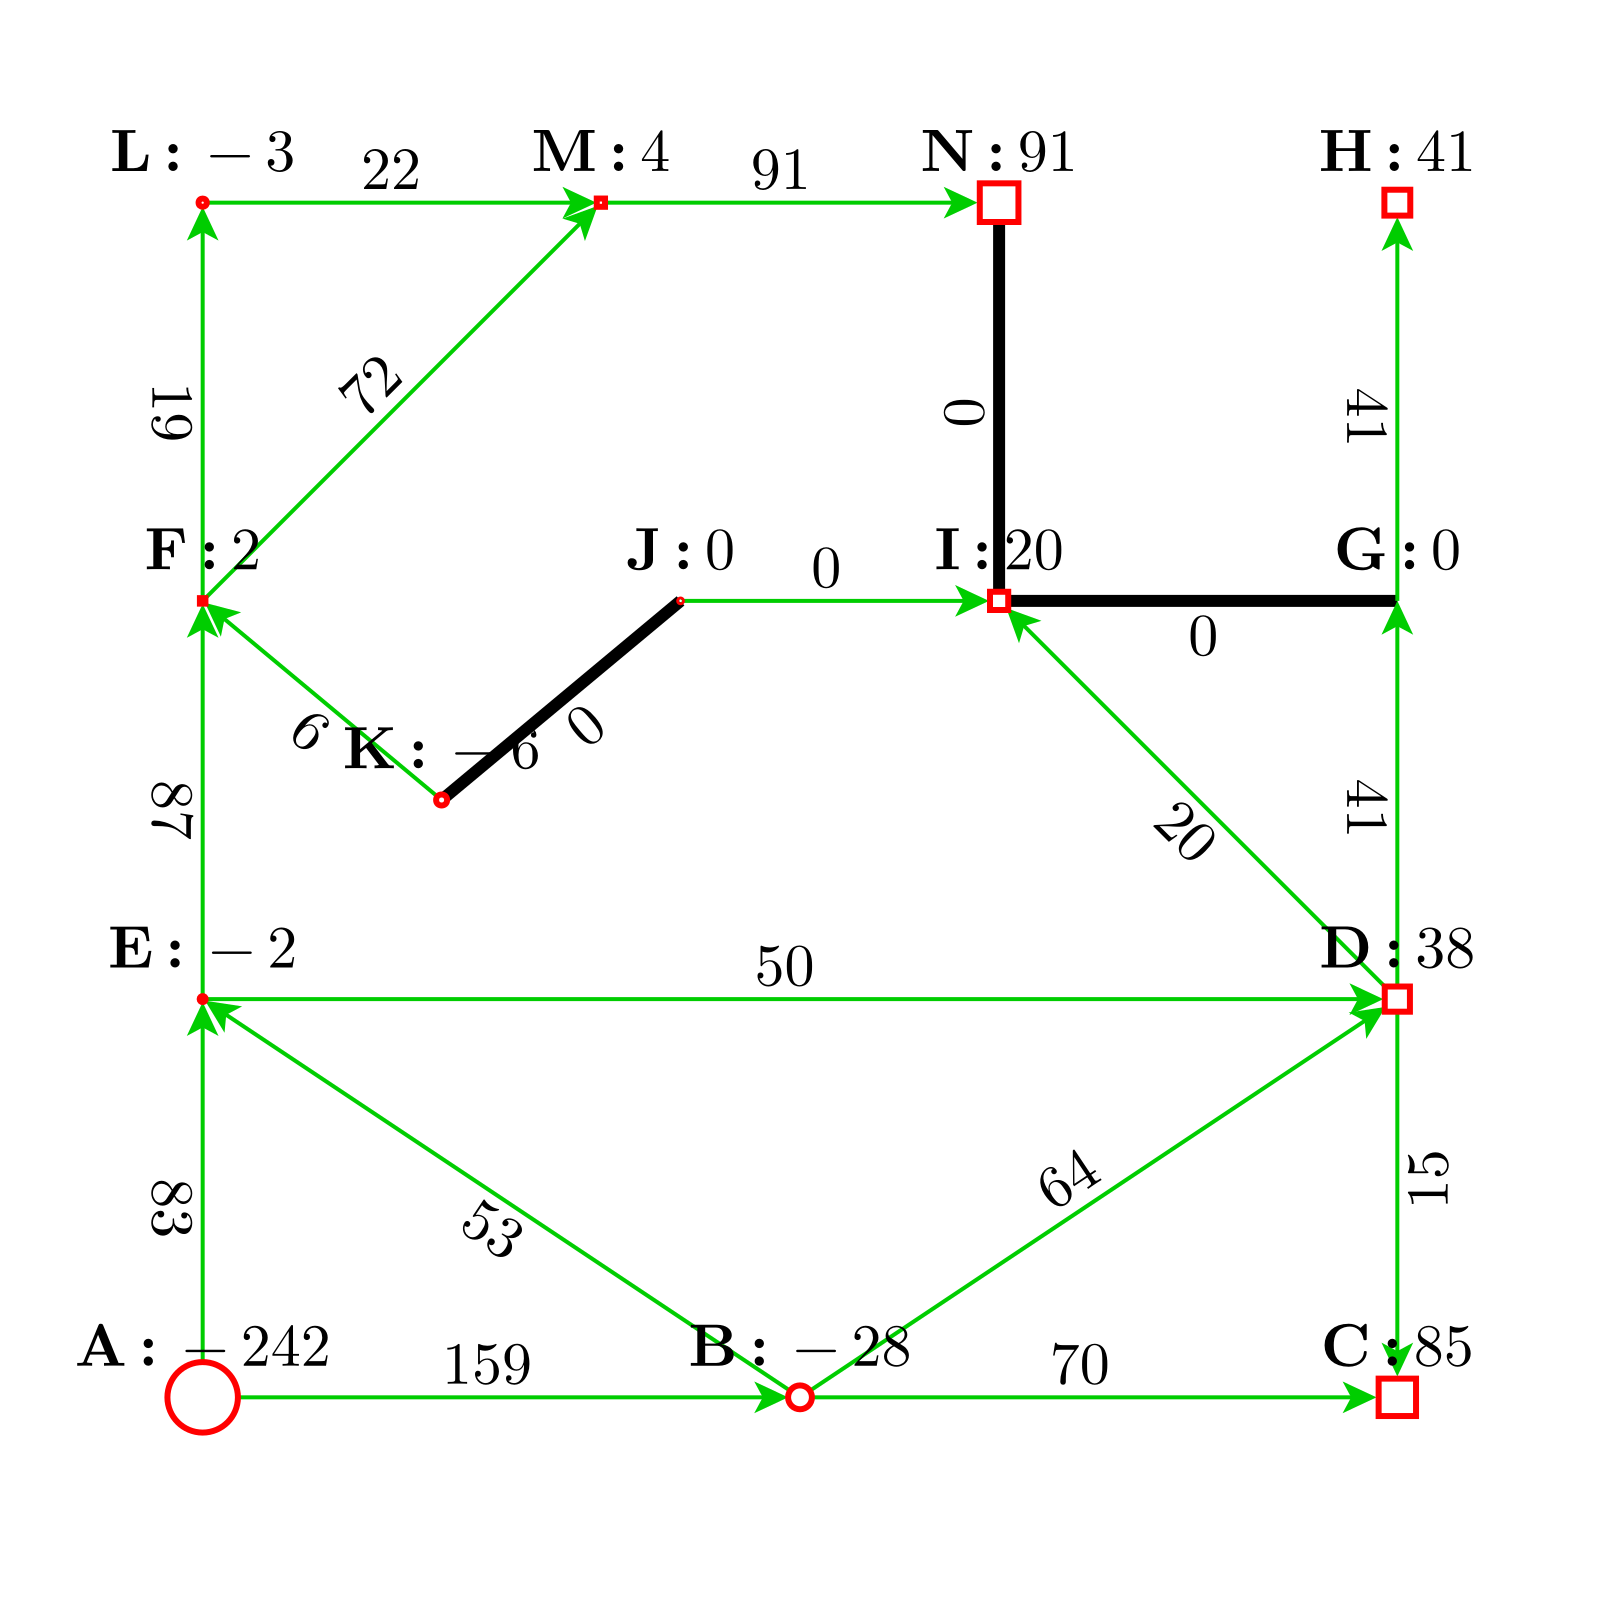

CairoMakie.Screen{IMAGE}


In [9]:
fig = Figure(size = (800, 800), fontsize = 30)
calcanddraw(g, bus_orig="A", outages = [6, 10, 19], layout = layout, fig=fig[1,1])
display(fig)

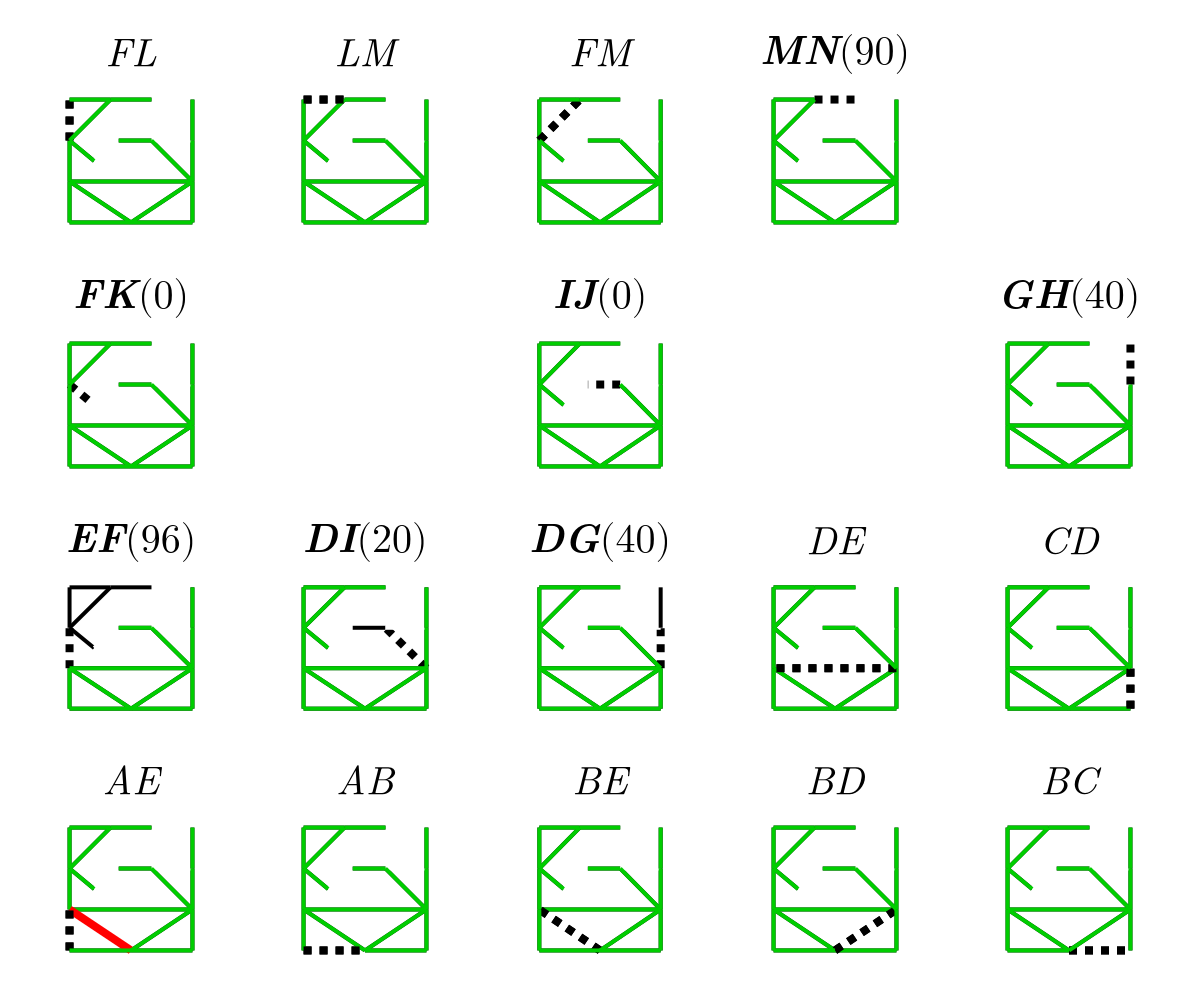

In [10]:
griddraw(g, "A", trips, [6, 10,19])

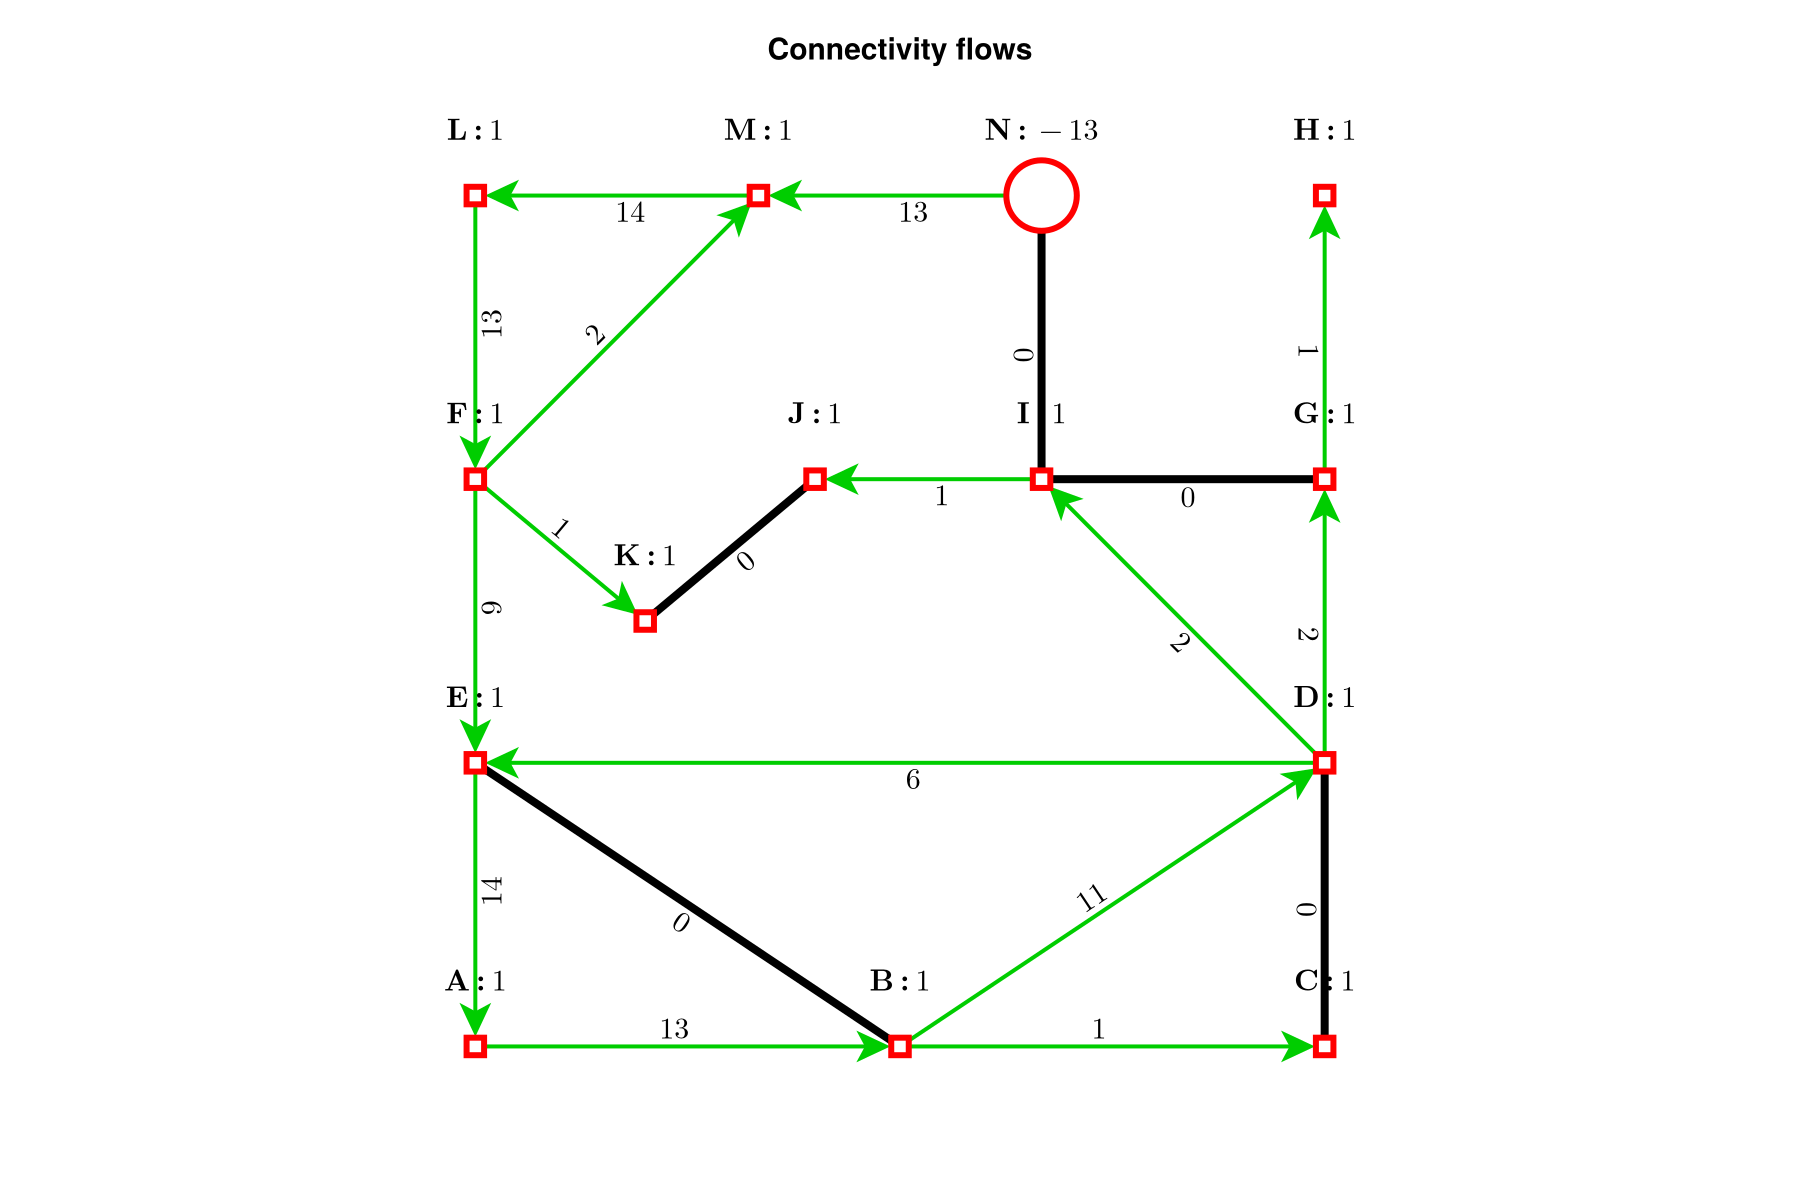

In [16]:
function c_model_to_graph(g, model, orig_bus)
    if !is_solved_and_feasible(model)
        @info "model not fesible"
        return
    else
        h=deepcopy(g)
        openings = [i for (i, v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
        _edges = collect(edges(h))
        for (i, f) in enumerate(value.(model[:c_flows]))
            br = e_index_for(h, _edges[i])
            br.p = f/100
        end
        for v in vertices(h)
            h[label_for(g, v)] = 1/100
        end
        h[orig_bus] = -(nv(h)-1)/100

        draw(h , outages = openings, layout = layout, title = "Connectivity flows");
    end
end

c_model_to_graph(g, model, "N")

In [12]:
code_for(g, "A")

12

In [19]:
println(collect(vertices(g)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [28]:
load = [g[label_for(g,v)] for v in vertices(g) if g[label_for(g,v)]>0]
S = sum(load)

3.73 / 2.80 / 20 * 100

# loss / (100 * S) 

6.6607142857142865